# C S 342 Final Project

## Overview

**Problem/Solution**

The project involves building a neural network to classify hand gestures from American Sign Language (ASL), specifically focusing on the 24 letters of the ASL alphabet (excluding J and Z, as they involve movement). The model aims to facilitate sign language recognition, which can enable individuals to communicate with technology or other people using sign language. Additionally, it could be expanded into touchless human-computer interactions, such as controlling devices or applications through hand gestures.


**Training Data**

The training data will be sourced from the Sign Language MNIST dataset, which contains grayscale 28x28 pixel images of hand gestures representing the 24 letters of the ASL alphabet and labeled with the corresponding ASL letter. The dataset was created by extending a small set of 1,704 uncropped color images. These images were then cropped around the hand region, converted to grayscale, resized, and augmented with over 50 variations per image using filters, random pixelation, brightness/contrast adjustments, and slight rotations. The final dataset includes 27,455 training images and 7,172 test images.


**Computational experiments**

Experiment 1 is an ablation study, where we remove or modify different parts of the model (e.g., regularization techniques, CNN layers, dropout, activation functions) to identify which components are most crucial for accurately classifying hand gestures. The goal is to better understand how the model differentiates between gestures and to find any critical features or architectural choices that improve classification performance.

Experiment 2 is a generalization study, in which the model trained on the Sign Language MNIST dataset will be evaluated on a different hand gesture dataset to test its ability to generalize and check for overfitting. If time permits, this experiment will also include testing the model in a real-time setting, where it classifies gestures from processed images captured via a camera feed.


## Loading and Understanding the Dataset

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader

In [118]:
# Load the training and test datasets

train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')
print(f"Test dataframe shape: {test_df.shape}")
print(f"Train dataframe shape: {train_df.shape}")
train_df.head()

Test dataframe shape: (7172, 785)
Train dataframe shape: (27455, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [119]:
# Check for nulls

print(f"Nulls in train: {train_df.isnull().sum().sum()}")
print(f"Nulls in test: {test_df.isnull().sum().sum()}")

Nulls in train: 0
Nulls in test: 0


In [120]:
# Check that all pixel values for between 0 and 255

print(f"Pixel value range in train: {train_df.iloc[:, 1:].min().min()} to {train_df.iloc[:, 1:].max().max()}")
print(f"Pixel value range in test: {test_df.iloc[:, 1:].min().min()} to {test_df.iloc[:, 1:].max().max()}")

Pixel value range in train: 0 to 255
Pixel value range in test: 0 to 255


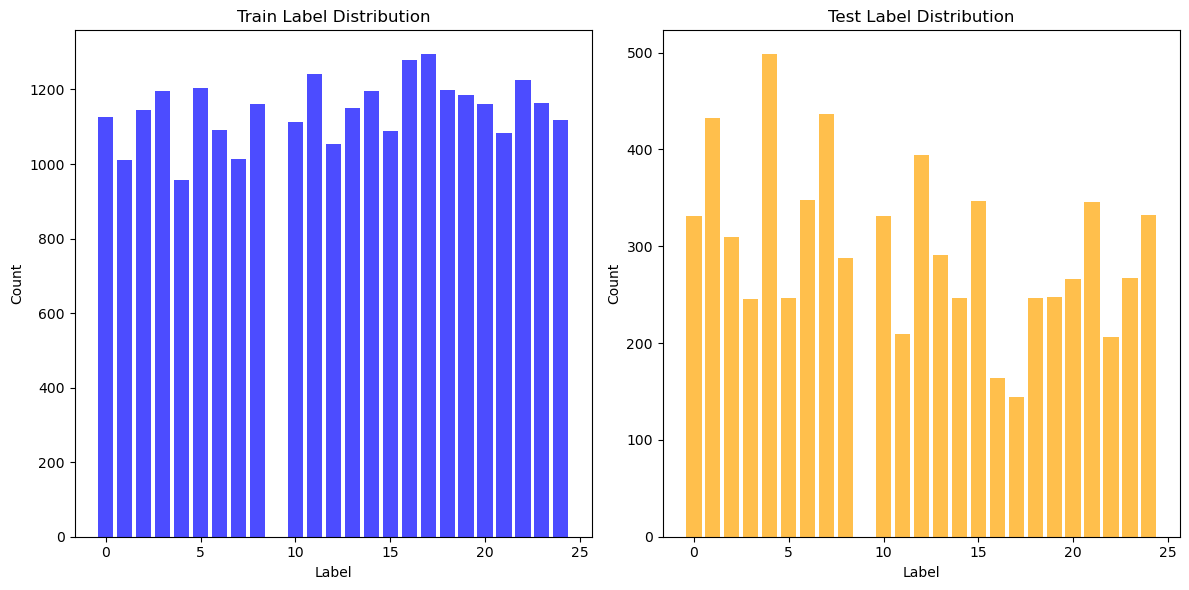

In [121]:
# Check dataset label distribution

train_labels = train_df['label'].value_counts()
test_labels = test_df['label'].value_counts()
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(train_labels.index, train_labels.values, color='blue', alpha=0.7)
plt.title('Train Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.bar(test_labels.index, test_labels.values, color='orange', alpha=0.7)
plt.title('Test Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

As we can see J (9) and Z (25) are excluded from the dataset as they involve movement.

In [122]:
# Separate the labels and features

y_train = train_df['label'].values
X_train = train_df.drop('label', axis=1).values

y_test = test_df['label'].values
X_test = test_df.drop('label', axis=1).values

In [123]:
# Reshape the data for CNN input (vector to grayscale image)

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [124]:
# Show final shape of the data

print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Train labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

Train data shape: (27455, 28, 28, 1)
Test data shape: (7172, 28, 28, 1)
Train labels shape: (27455,)
Test labels shape: (7172,)


In [125]:
# Create mappings from label to letter and vice versa except for J and Z

label_to_letter = {i: chr(i + 65) for i in range(26)}
del label_to_letter[9]  # J
del label_to_letter[25] # Z
letter_to_label = {v: k for k, v in label_to_letter.items()}

print(f"Label to letter mapping: {label_to_letter}")
print(f"Letter to label mapping: {letter_to_label}")

Label to letter mapping: {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'}
Letter to label mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24}


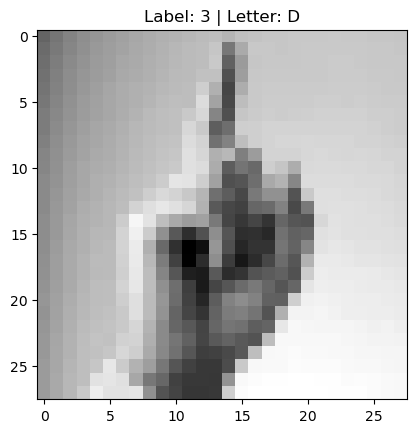

In [126]:
# Show a sample image

plt.imshow(X_train[0].reshape(28, 28), cmap='gray')
plt.title(f"Label: {y_train[0]} | Letter: {label_to_letter[y_train[0]]}")
plt.show()

In [127]:
# Convert the data to PyTorch tensors

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [128]:
# Create TensorDatasets and DataLoaders

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [129]:
# Check that the DataLoader works

for images, labels in train_loader:
    print("Batch image shape:", images.shape)  # Expected: [64, 1, 28, 28]
    print("Batch label shape:", labels.shape)  # Expected: [64]
    break

Batch image shape: torch.Size([64, 1, 28, 28])
Batch label shape: torch.Size([64])


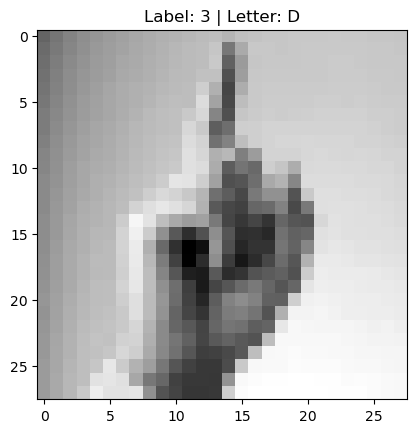

In [130]:
# Check that images are still in the correct format after tensor conversion

plt.imshow(X_train_tensor[0].squeeze().numpy(), cmap='gray')
plt.title(f"Label: {y_train_tensor[0].item()} | Letter: {label_to_letter[y_train_tensor[0].item()]}")
plt.show()


## Training the Model

In [138]:
import torch.nn as nn

class SignLanguageCNN(nn.Module):
    def __init__(self):
        super(SignLanguageCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 26)
        )

    def forward(self, x):
        return self.model(x)


In [139]:
model = SignLanguageCNN()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images, labels 

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch [1/20], Loss: 1105.5096, Accuracy: 28.87%
Epoch [2/20], Loss: 439.1361, Accuracy: 74.09%
Epoch [3/20], Loss: 169.3551, Accuracy: 93.05%
Epoch [4/20], Loss: 70.8027, Accuracy: 98.21%
Epoch [5/20], Loss: 34.4201, Accuracy: 99.42%
Epoch [6/20], Loss: 20.7498, Accuracy: 99.66%
Epoch [7/20], Loss: 12.8208, Accuracy: 99.91%
Epoch [8/20], Loss: 9.1214, Accuracy: 99.90%
Epoch [9/20], Loss: 6.6883, Accuracy: 99.93%
Epoch [10/20], Loss: 4.7566, Accuracy: 99.95%
Epoch [11/20], Loss: 3.5596, Accuracy: 99.98%
Epoch [12/20], Loss: 3.0056, Accuracy: 99.96%
Epoch [13/20], Loss: 2.9547, Accuracy: 99.96%
Epoch [14/20], Loss: 2.1959, Accuracy: 99.97%
Epoch [15/20], Loss: 1.8417, Accuracy: 99.98%
Epoch [16/20], Loss: 1.7575, Accuracy: 99.97%
Epoch [17/20], Loss: 1.9453, Accuracy: 99.96%
Epoch [18/20], Loss: 0.8642, Accuracy: 100.00%
Epoch [19/20], Loss: 0.9348, Accuracy: 99.97%
Epoch [20/20], Loss: 0.6791, Accuracy: 99.99%


In [141]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images, labels
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 98.10%
